## Changing the cell width to 100%

In [8]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:78% !important; }</style>"))

## Loading the required libraries

In [56]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
from torch.autograd.variable import Variable
from torch import optim
import torch.nn.functional as F

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Functions

### underlined_text()

In [57]:
def underlined_text(text, char = '='):
    length = len(text)
    print(text)
    print(char*length)

### sample_z()

Generates a sample from the latent distribution N($\mu$, $\sigma^2$). To generate this sample we use the formula

> $\mu + \sigma\epsilon $

where $\epsilon$ ~ $N(0,1)$.

Note that, we pass log of variance ($\log\sigma^2$) to the function (not $\sigma^2$).

In [58]:
def sample_z(mean, log_variance):
    eps = Variable(torch.randn(mean.size())).to(device)
    return mean + torch.exp(log_variance/2) * eps

### KL divergence loss function

The KL divergence loss for a VAE for a single sample is defined as
> $\frac{1}{2}$ \[$\Sigma_i \sigma_i^2 + \Sigma_i \mu_i^2 - \Sigma_i(\log \sigma_i^2 + 1) $\]
where $\mu_i$ and $\sigma_i^2$ are mean and variance of $i$ the component.

In [59]:
def kl_loss_fn(mean, log_variance):
    return 0.5 * torch.sum(
        torch.exp(log_variance) #sigma_sqr
        + mean**2 # mu_sqr
        - log_variance # log(sigma_sqr)
        - 1
    )

### Convert images to vectors 

In [60]:
def images2vectors(images):
    '''
    Converts batch of image tensors to batch of 1D tensors
    '''
    return images.view(images.shape[0], 784)

### Convert vectors to images

In [61]:
def vectors2images(vectors):
    '''
    Converts a batch 1D tensors to batch of 2D images 
    '''
    return vectors.view(vectors.shape[0], 1, 28, 28)

### Noise

In [62]:
def noise(size, latent_dim):
    '''
    Generates a 1D tensor of Gausian random sampled values from N(0,1)
    '''
    n = Variable(torch.randn(size, latent_dim))
    return n    

## Loading the MNIST dataset

### Downloading train and test datasets

In [63]:
#Loading training data
train = datasets.MNIST(
    root="", #Folder where the dataset to be stored; empty means stored in current folder
    train=True, #Download the 'training' dataset, False => download 'test' dataset
    download=True, #Should be 'True' in the first time downling the dataset, else 'False'
    transform=transforms.Compose([transforms.ToTensor()])
)

#Loading test data
test = datasets.MNIST(
    root="",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

### Wraping downloaded datasets into data loaders

In [64]:
from torch.utils.data import DataLoader

trainDL = DataLoader(train, batch_size=8, shuffle=True)
testDL  = DataLoader(test, batch_size=8, shuffle=True)
print("Batch size = ", trainDL.batch_size)
print("Batch size = ", testDL.batch_size)

Batch size =  8
Batch size =  8


### Getting the first batch of images and their labels

In [65]:
data_itr = iter(trainDL)
first_batch_of_images, first_batch_of_labels = data_itr.next()
print(first_batch_of_images.shape)

torch.Size([8, 1, 28, 28])


## Classes

### Encoder class

For the computational convenient, it is assumed that the encoder produces mean ($\mu$) and log of variance ($\log \sigma^2$), instead of variance ($\sigma^2$), where $\mu$ and $\sigma^2$ are mean and variance of the latent distribution (Gaussian distribution).

In [66]:
class Encoder(torch.nn.Module):
    '''
    Encoder part of VAE
    '''
    def __init__(self, input_dim, hidden_dim, z_dim):
        '''
        Args:
        input_dim: Size of the input (e.g. For MNIST, 28*28)
        hidden_dim: Size of the hidden layer
        z_dim: Latent dimension
        '''
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, z_dim)
        self.fc3 = nn.Linear(hidden_dim, z_dim)      
        
    def forward(self, x):
        '''
        Shape of x should be (batch_size, input_dim)
        '''
        hidden_out = F.relu(self.fc1(x))
        mean = self.fc2(hidden_out)
        log_variance = self.fc3(hidden_out)
        
        return mean, log_variance

### Decoder class

In [67]:
class Decoder(torch.nn.Module):
    '''
    Decoder part of VAE
    '''
    def __init__(self, z_dim, hidden_dim, output_dim):
        '''
        Args:
        z_dim: Latent dimension
        hidden_dim: Size of the hidden layer
        output_dim: Size of the output (e.g. For MNIST, 28*28)
        '''
        
        super(Decoder, self).__init__()
        
        self.fc1 = nn.Linear(z_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        '''
        Shape of x should be (batch_size, z_dim)
        '''
        hidden_out = F.relu(self.fc1(x))
        reconstructed_input = torch.sigmoid(self.fc2(hidden_out))
        
        return reconstructed_input

### VAE class

In [68]:
class VAE(nn.Module):
    '''
    VAE which takes Encoder and Decoder classes
    '''
    def __init__(self, enc, dec):
        '''
        Args:
        enc: Object of Encoder class
        dec: Object of Decoder class
        '''

        super(VAE, self).__init__()

        self.enc = enc
        self.dec = dec

    def forward(self, x):
        '''
        Returns the reconstructed input, mu and log_sigma
        '''
        # Encoding
        mean, log_variance = self.enc(x)
        # Generates a sample from the latenet space
        z = sample_z(mean, log_variance)
        # Decoding
        reconstructed_input = self.dec(z)
        
        return reconstructed_input, mean, log_variance

## Training

### Defining parameters

In [69]:
INPUT_DIM = 28*28
HIDDEN_DIM = 256
LATENT_DIM = 32
LR = 1E-3
EPOCHS = 10

### Defining the model

In [70]:
# Encoder
encoder = Encoder(input_dim=INPUT_DIM, hidden_dim=HIDDEN_DIM, z_dim=LATENT_DIM)
underlined_text("Encoder")
print(encoder)
print()
# Decoder
decoder = Decoder(z_dim=LATENT_DIM, hidden_dim=HIDDEN_DIM, output_dim=INPUT_DIM)
underlined_text("Decoder")
print(decoder)
print()
model = VAE(enc=encoder, dec=decoder).to(device)
underlined_text("Model")
print(model)

Encoder
Encoder(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=32, bias=True)
  (fc3): Linear(in_features=256, out_features=32, bias=True)
)

Decoder
Decoder(
  (fc1): Linear(in_features=32, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=784, bias=True)
)

Model
=====
VAE(
  (enc): Encoder(
    (fc1): Linear(in_features=784, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=32, bias=True)
    (fc3): Linear(in_features=256, out_features=32, bias=True)
  )
  (dec): Decoder(
    (fc1): Linear(in_features=32, out_features=256, bias=True)
    (fc2): Linear(in_features=256, out_features=784, bias=True)
  )
)


### Optimizer

In [71]:
optimizer = optim.Adam(model.parameters(), lr=LR)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)


### Reconstruction loss

In [72]:
reconstruct_loss_fn = nn.BCELoss(reduction='sum')
print(reconstruct_loss_fn)

BCELoss()


### Training

In [73]:
for epoch in range(EPOCHS):
    kl_losses = []
    r_losses = []
    for data in trainDL:
        images, _ = data
        x = images2vectors(images).to(device)
        optimizer.zero_grad()
        x_reconstructed, mean, log_variance = model(x)
        kl_loss = kl_loss_fn(mean, log_variance)
        kl_losses.append(kl_loss)
        reconstructed_loss = reconstruct_loss_fn(x_reconstructed, x)
        r_losses.append(reconstructed_loss)
        loss = reconstructed_loss + kl_loss
        loss.backward()
        optimizer.step()
    print("Epoch [{:5d}/{:5d}] | mean_kl_loss: {:8.4f} | mean_reconstruct_loss: {:8.4f} |".
          format(epoch+1, EPOCHS, torch.mean(torch.FloatTensor(kl_losses)), 
                 torch.mean(torch.FloatTensor(r_losses))))

Epoch [    1/   10] | mean_kl_loss: 172.2651 | mean_reconstruct_loss: 879.2253 |
Epoch [    2/   10] | mean_kl_loss: 196.9343 | mean_reconstruct_loss: 714.3771 |
Epoch [    3/   10] | mean_kl_loss: 199.7570 | mean_reconstruct_loss: 692.4107 |
Epoch [    4/   10] | mean_kl_loss: 201.1804 | mean_reconstruct_loss: 682.0749 |
Epoch [    5/   10] | mean_kl_loss: 202.3439 | mean_reconstruct_loss: 675.3754 |
Epoch [    6/   10] | mean_kl_loss: 202.6615 | mean_reconstruct_loss: 671.2531 |
Epoch [    7/   10] | mean_kl_loss: 202.7513 | mean_reconstruct_loss: 667.6504 |
Epoch [    8/   10] | mean_kl_loss: 202.7982 | mean_reconstruct_loss: 665.3290 |
Epoch [    9/   10] | mean_kl_loss: 203.1366 | mean_reconstruct_loss: 662.9523 |
Epoch [   10/   10] | mean_kl_loss: 203.0079 | mean_reconstruct_loss: 661.1951 |


## Testing VAE

### Generating new images from the trained decoder

In [74]:
from torchvision.utils import save_image
import matplotlib.pyplot as plt

with torch.no_grad():
    noise_test = noise(size=32, latent_dim=LATENT_DIM).to(device)
    print("Noise test shape = ", noise_test.shape)
    
    # Run only the decoder (generating new images)
    fake_imgs_vecs = model.dec(noise_test)
    print("Fake image vectors shape = ", fake_imgs_vecs.shape)
    fake_imgs = fake_imgs_vecs.view(fake_imgs_vecs.shape[0], 1, 28, 28)
    print("Fake image shape = ", fake_imgs.shape)
    save_image(fake_imgs, 'VAE_Gen_Imgs' + '.png')

Noise test shape =  torch.Size([32, 32])
Fake image vectors shape =  torch.Size([32, 784])
Fake image shape =  torch.Size([32, 1, 28, 28])


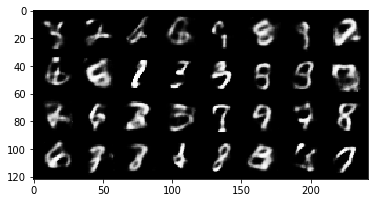

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from torchvision import utils

#Functions to show an image
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
imshow(utils.make_grid(fake_imgs.detach().to('cpu')))

### Reconstructed images of first batch of training images

torch.Size([8, 1, 28, 28])
torch.Size([8, 784])
torch.Size([8, 1, 28, 28])

Original


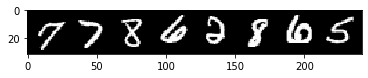


Reconstructed


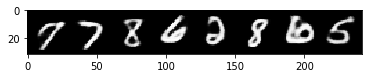

In [76]:
for data in trainDL:
    images, _ = data
    print(images.shape)
    x = images2vectors(images).to(device)
    print(x.shape)
    x_recon, _, _ = model(x)
    recon_imgs = x_recon.view(x_recon.shape[0], 1, 28, 28)
    print(recon_imgs.shape)
    print()
    print("Original")
    imshow(utils.make_grid(images))
    print()
    print("Reconstructed")    
    imshow(utils.make_grid(recon_imgs.detach().to('cpu')))
    break

### Testing the trained VAE on FashionMNIST

In [77]:
#Loading training data
trainFashion = datasets.FashionMNIST(
    root="", #Folder where the dataset to be stored; empty means stored in current folder
    train=True, #Download the 'training' dataset, False => download 'test' dataset
    download=True, #Should be 'True' in the first time downling the dataset, else 'False'
    transform=transforms.Compose([transforms.ToTensor()])
)

#Loading test data
testFashion = datasets.FashionMNIST(
    root="",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)

In [78]:
from torch.utils.data import DataLoader

trainFashionDL = DataLoader(trainFashion, batch_size=8, shuffle=True)
testFashionDL  = DataLoader(testFashion, batch_size=8, shuffle=True)
print("Batch size = ", trainFashionDL.batch_size)
print("Batch size = ", testFashionDL.batch_size)

Batch size =  8
Batch size =  8


torch.Size([8, 1, 28, 28])
torch.Size([8, 784])
torch.Size([8, 1, 28, 28])

Original


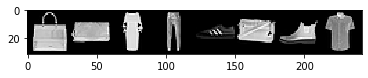


Reconstructed


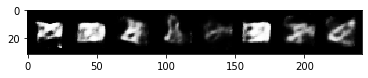

In [79]:
for data in trainFashionDL:
    images, _ = data
    print(images.shape)
    x = images2vectors(images).to(device)
    print(x.shape)
    x_recon, _, _ = model(x)
    recon_imgs = x_recon.view(x_recon.shape[0], 1, 28, 28)
    print(recon_imgs.shape)
    print()
    print("Original")    
    imshow(utils.make_grid(images))
    print()
    print("Reconstructed")    
    imshow(utils.make_grid(recon_imgs.detach().to('cpu')))
    break